In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.transforms
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import numpy as np
from keypoint_detection.utils.heatmap import gaussian_heatmap, generate_keypoints_heatmap, overlay_image_with_heatmap, get_keypoints_from_heatmap
from keypoint_detection.models.models import KeypointDetector
from keypoint_detection.data.datamodule import BoxKeypointsDataModule
from keypoint_detection.data.dataset import  BoxKeypointsDataset, BoxDatasetPreloaded, BoxDatasetIOCatcher
from keypoint_detection.data.unlabeled_dataset import UnlabeledBoxDataset

In [2]:
import wandb
from pathlib import Path
from skimage import io
import torchvision

In [4]:
## Get Model checkpoint from wandb


checkpoint_reference = "airo-box-manipulation/box_dataset_04_02/model-k3plhnyf:latest"

# download checkpoint locally (if not already cached)
run = wandb.init(project="test-project", entity="airo-box-manipulation")
artifact = run.use_artifact(checkpoint_reference, type="model")
artifact_dir = artifact.download()

# 
checkpoint = torch.load(Path(artifact_dir) / "model.ckpt")
print(checkpoint["hyper_parameters"])
# load checkpoint
model = KeypointDetector.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", backbone='Unet')

wandb: Currently logged in as: tlips (use `wandb login --relogin` to force relogin)


{'heatmap_sigma': 2, 'detect_flap_keypoints': True, 'maximal_gt_keypoint_pixel_distances': [2.0, 4.0], 'minimal_keypoint_extraction_pixel_distance': None, 'learning_rate': 0.0004, 'backbone': UnetBackbone(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (downsampling_blocks): ModuleList(
    (0): StridedDownSamplingBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU(inplace=True)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): StridedDownSamplingBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU(inplace=True)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [5]:
IMAGE_DIR = UnlabeledBoxDataset.get_data_dir_path() / "real_data_2021_12_09"
JSON_PATH = UnlabeledBoxDataset.get_data_dir_path() / "real_data_2021_12_09" / "dataset.json"
dataset = UnlabeledBoxDataset(JSON_PATH,IMAGE_DIR)
print(len(dataset))
dataloader = torch.utils.data.DataLoader(dataset, batch_size= 8, shuffle= True)

69


In [6]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()


In [7]:
transform  = torchvision.transforms.Resize((256,256))

In [13]:
def show_results(type = "corner", show_extracted_keypoints = True, mode ="eval"):
    """
    show network outputs on the dataset.
    """
    plt.rcParams["figure.figsize"] = (20,3)
    pil_to_torch = torchvision.transforms.ToTensor()
    if mode == "eval":
        model.eval()
    else:
        model.train()
    for batch in iter(dataloader):
        with torch.no_grad():
            batch = transform(batch)
            channel = 1 if type == "flap" else 0
            output = model(batch)[:,channel]
            if not show_extracted_keypoints:
                overlayed_heatmap = torch.stack(
                    [
                        pil_to_torch(overlay_image_with_heatmap(batch[i], torch.unsqueeze(output[i].cpu(), 0),0.6))
                        for i in range(batch.shape[0])
                    ]
                )
            else:
                n_keypoints = 4 if type == "corner" else 8
                overlayed_heatmap = torch.stack(
                [
                    pil_to_torch(
                        overlay_image_with_heatmap(
                            batch[i],
                            torch.unsqueeze(
                                generate_keypoints_heatmap(
                                    batch.shape[-2:],

                                    get_keypoints_from_heatmap(output[i].cpu(), 1,n_keypoints),
                                    sigma=2,
                                    device = 'cpu'
                                ),
                                0,
                            ),
                            0.6
                        )
                    )
                    for i in range(batch.shape[0])
                ]
        )
        grid = torchvision.utils.make_grid(overlayed_heatmap, nrow=8)
        imshow(grid)


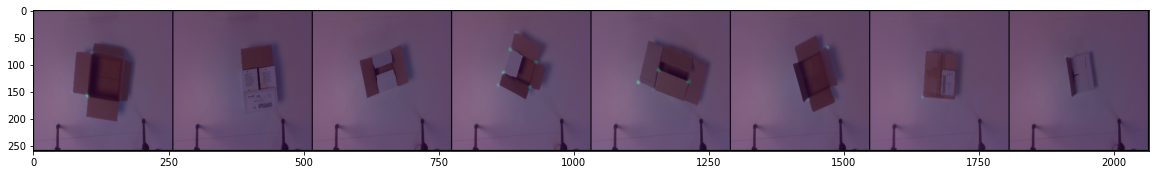

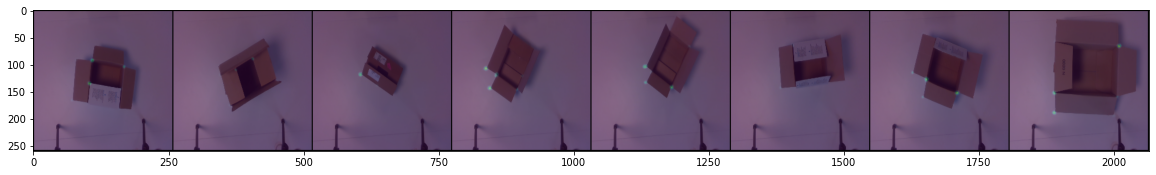

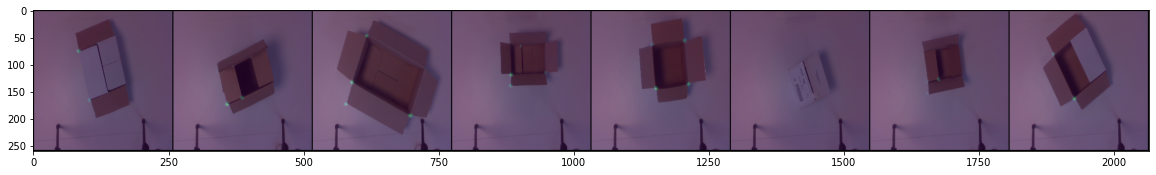

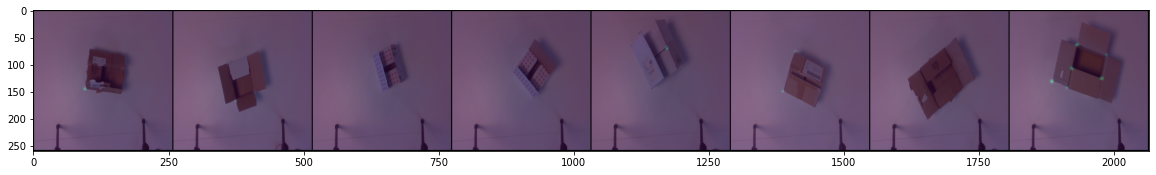

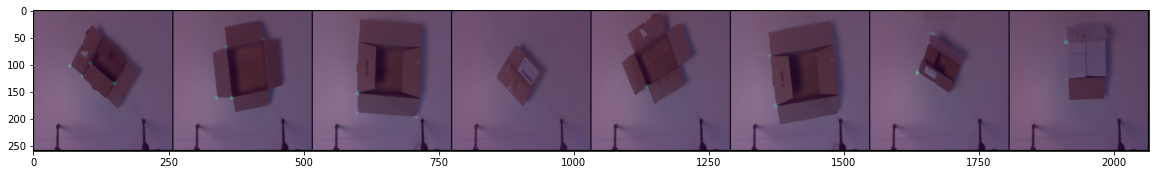

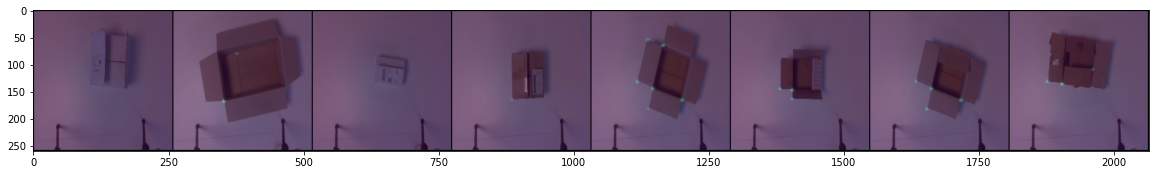

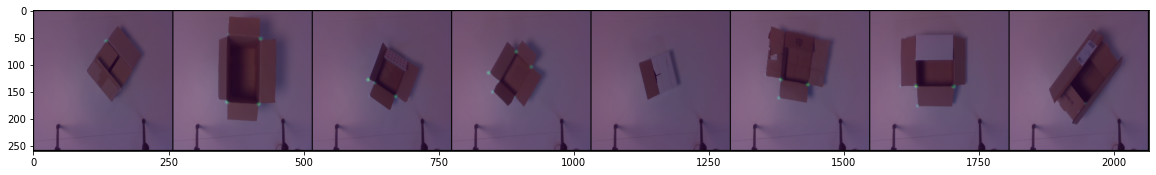

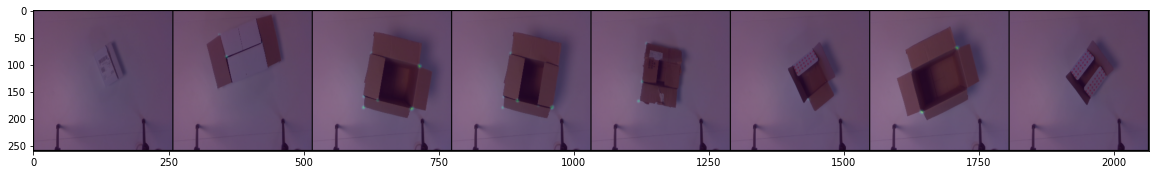

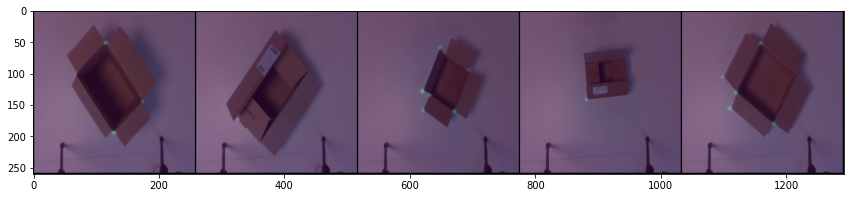

In [16]:
show_results("corner",False)

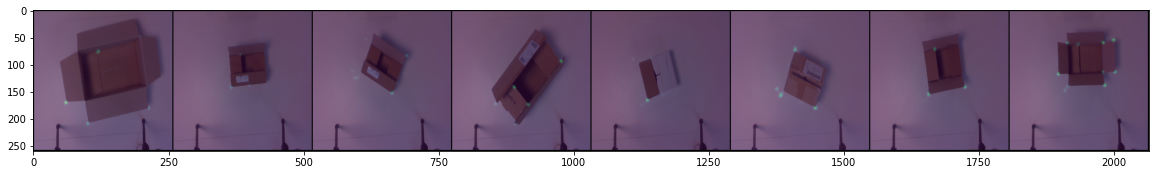

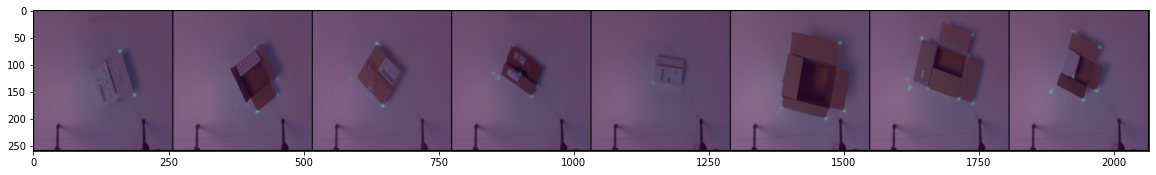

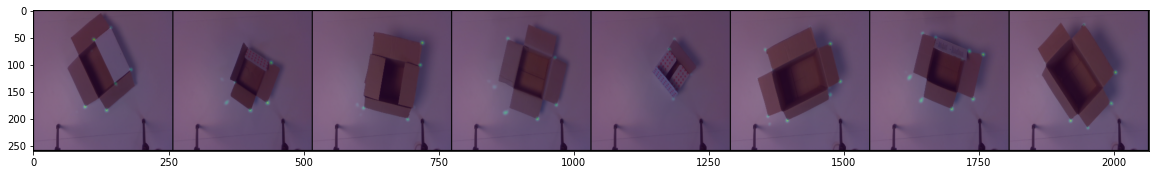

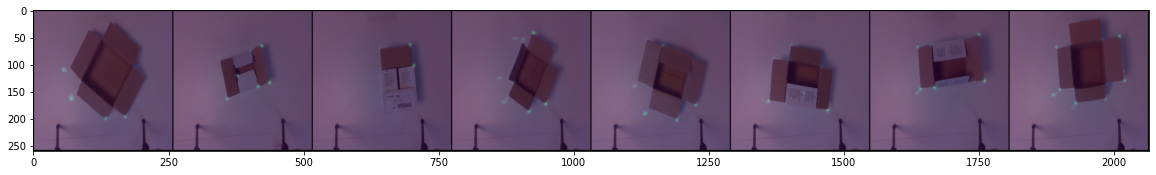

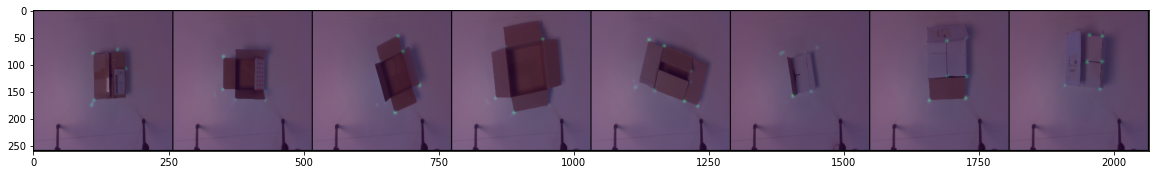

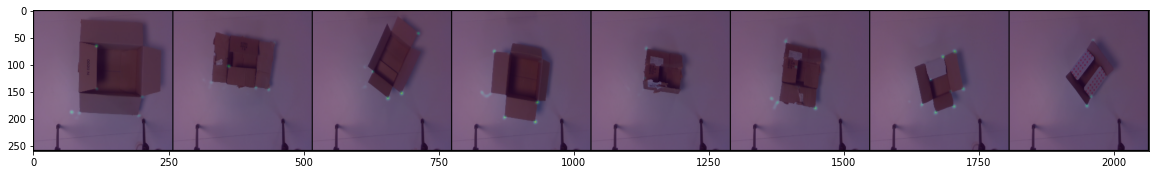

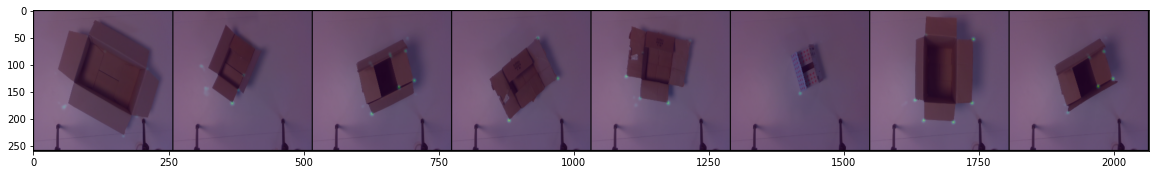

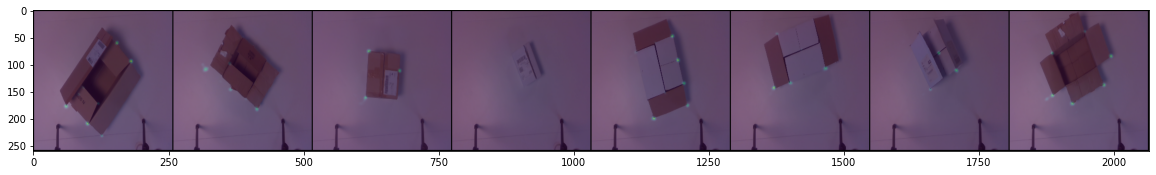

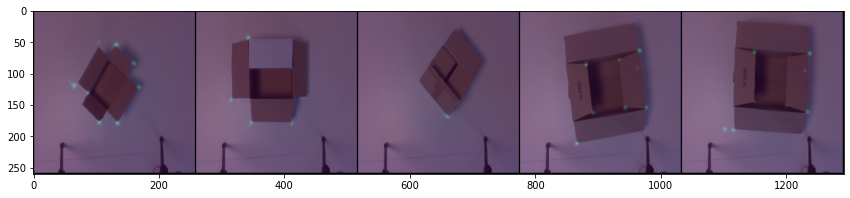

In [18]:
show_results("flap", False)